In [10]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import xarray as xr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns


# Bring in data

In [2]:
df = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv')
solutions = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAINING_SOLUTIONS.csv')
df_labeled = df.merge(solutions, how='inner', on='participant_id')


## Transform to arrays

In [4]:
region_pairs = []
for col in df_labeled.columns:
    try:
        i, j = col.split('throw_')
        i = int(i)  # Convert "0throw" → 0
        j = int(j.replace('thcolumn', ''))  # Convert "2thcolumn" → 2
        region_pairs.append((i, j))
    except ValueError:
        print(f"Skipping malformed column: {col}")

region_pairs = np.array(region_pairs)


Skipping malformed column: participant_id
Skipping malformed column: ADHD_Outcome
Skipping malformed column: Sex_F


In [5]:
def reshape_to_matrix(patient_data):
    matrix = np.zeros((199, 199))  # Initialize 199x199 matrix
    
    for idx, (i, j) in enumerate(region_pairs):
        matrix[i, j - 1] = patient_data[idx]  # Subtract 1 from j

    return matrix


In [6]:
connectomes = np.array([reshape_to_matrix(row) for _, row in df.iloc[:,1:].iterrows()])

/var/folders/9v/6bsrztp11777s06bs8q25y2h0000gn/T/ipykernel_28801/1768268947.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  matrix[i, j - 1] = patient_data[idx]  # Subtract 1 from j


In [204]:
# (# of participants, rows, columns in grid)
pd.Series(connectomes[540].flatten())

0       -0.108068
1        0.091754
2       -0.002836
3        0.017706
4        0.130521
           ...   
39596    0.000000
39597    0.000000
39598    0.000000
39599    0.000000
39600    0.034577
Length: 39601, dtype: float64

## Labels

In [7]:
adhd_idx = df_labeled[df_labeled['ADHD_Outcome']==1].index.tolist()
no_adhd_idx = df_labeled[df_labeled['ADHD_Outcome']==0].index.tolist()

# Feature Eng

## Standardized difference (Cohen's d-like measure)

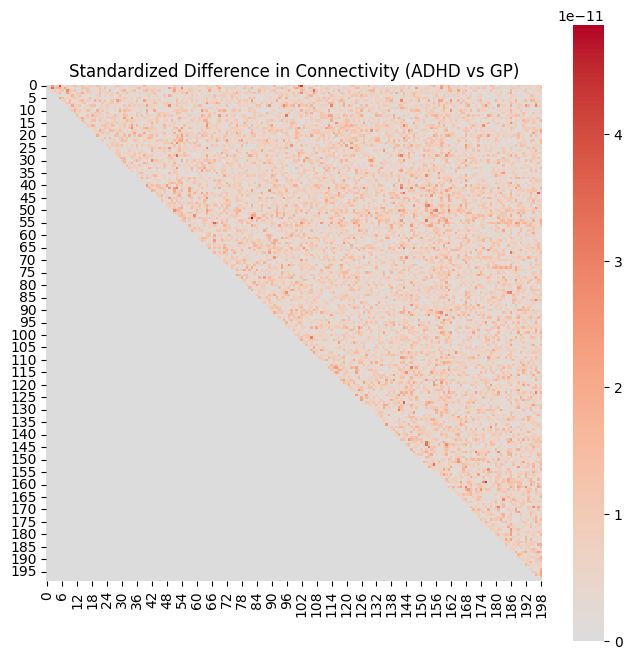

<Axes: >

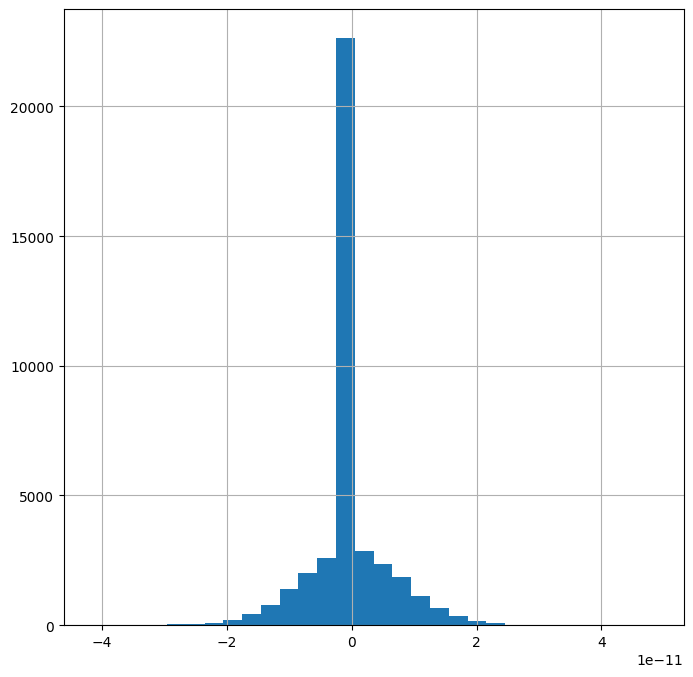

In [21]:

plt.figure(figsize=(8,8))
# Get standard deviations for each group
adhd_std = np.std(connectomes[adhd_idx], axis=0)
pop_std = np.std(connectomes, axis=0)

adhd_mean = np.mean(connectomes[adhd_idx], axis=0)
pop_mean = np.mean(connectomes, axis=0)
epsilon = 1e8 # what they say to use for ML. 1e10 is fine too though

# Pooled standard deviation
n_adhd = len(adhd_idx)
n_control = len(no_adhd_idx)

# pooled_std = np.sqrt(((n_adhd-1)*adhd_std**2 + (n_control-1)*control_std**2) / 
#                      (n_adhd + n_control - 2))

# Standardized difference
effect_size = (adhd_mean - pop_mean) / (pop_std+ epsilon)

# Plot standardized difference
sns.heatmap(abs(effect_size), cmap='coolwarm', square=True, 
            cbar=True, center=0)#, vmin=-2, vmax=2)
plt.title('Standardized Difference in Connectivity (ADHD vs GP)')
#plt.tight_layout()
plt.show()

plt.figure(figsize=(8,8))
pd.Series((effect_size).flatten()).hist(bins=30)


In [206]:
effect_size[0]

array([ 3.94508704e-12, -2.79250189e-12,  2.31368880e-11,  9.65259742e-12,
        1.29901219e-11, -4.05891673e-11, -9.10020454e-12, -3.11431132e-12,
       -9.10774795e-12, -1.29913861e-12,  9.66537593e-12,  1.30545699e-11,
       -6.95834539e-12, -5.78990005e-12,  1.17991454e-11,  1.36152547e-12,
       -6.01519770e-12, -1.10989977e-11, -8.18087637e-12,  8.48495505e-12,
       -1.35387057e-11, -7.24375730e-12,  8.27280825e-13,  6.78178246e-12,
       -4.81238142e-12, -1.38049811e-12, -1.41134500e-12, -3.19109821e-12,
       -1.28656215e-11, -9.19019868e-12, -7.04714170e-13, -3.52692368e-12,
       -1.64611397e-12, -5.76572613e-12,  4.97893426e-12,  7.04240933e-12,
       -1.86587439e-12,  2.40981843e-12, -2.45285205e-12,  1.66832660e-11,
       -2.72349984e-12,  5.06612410e-12, -5.77931562e-12,  2.16885486e-12,
       -6.40262507e-12,  4.57375202e-12,  3.27581267e-12,  1.77651645e-12,
       -2.59931801e-12, -2.47400557e-12,  2.60257830e-13,  8.63753891e-12,
       -7.45362681e-12, -

In [20]:
pd.Series(effect_size.flatten()).describe()

count    3.960100e+04
mean    -9.044480e-15
std      5.956628e-12
min     -4.166843e-11
25%     -7.746388e-14
50%      0.000000e+00
75%      1.706478e-14
max      4.864948e-11
dtype: float64

### Per patient

<Axes: >

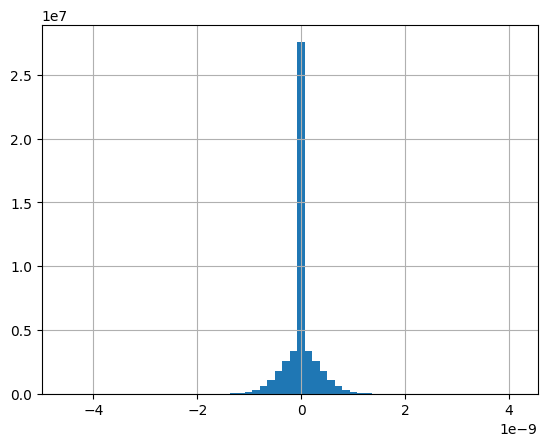

In [54]:
es_per_patient= (connectomes - pop_mean) / (pop_std+ epsilon)
pd.Series(((connectomes - pop_mean) / (pop_std+ epsilon)).flatten()).hist(bins=60)

In [52]:
pd.Series(((connectomes - pop_mean) / (pop_std+ epsilon))[0].flatten()).value_counts()

 0.000000e+00    19701
 3.292041e-10        1
 2.219100e-10        1
 6.673067e-11        1
-4.777437e-10        1
                 ...  
-5.068687e-10        1
-4.421414e-11        1
-1.090922e-10        1
 1.935371e-10        1
 1.442625e-10        1
Name: count, Length: 19901, dtype: int64

In [51]:
199*199

39601

In [53]:

# for thresh in np.arange(.1,.25,.05):
#     plt.figure()
#     hold = []

#     for i in np.arange(connectomes.shape[0]):
#         hold.append(np.sum(np.abs(get_upper_triangle_features(connectomes[i]))>=thresh))
    
#     pd.Series(hold).hist(alpha=.5, label=f'{thresh}')
#     plt.legend()

## Extract only the top right triangle for each patient

In [87]:
def get_upper_triangle_features(matrix):
    # Get upper triangle indices
    indices = np.triu_indices_from(matrix, k=1)  # k=1 excludes diagonal
    # Return the values at these indices
    return matrix[indices]#, indices

In [126]:
vals = np.array([get_upper_triangle_features(conn) for conn in es_per_patient])

In [129]:
vals[0]

array([ 2.45878068e-10,  7.62481454e-11, -2.61455523e-10, ...,
        6.26623740e-10, -1.17123521e-09,  4.41792262e-10])

### UMAP

In [168]:
import umap 
reducer = umap.UMAP(random_state=42, n_neighbors=30, n_components=3)

In [169]:
# just to understand the data structure...
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape) # you call .fit() on this object..
print(digits.images.shape)

(1797, 64)
(1797, 8, 8)


In [170]:
digits.data[0] == digits.images[0].flatten()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [171]:
vals.shape

(1213, 19701)

In [172]:
reducer.fit(vals)

/Users/paigegiese/SYG/wids-2025-mupd/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_components=3, n_jobs=1, n_neighbors=30, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [173]:
embedding = reducer.transform(vals)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape


(1213, 3)

In [174]:
embedding[:, 1]

array([4.702104 , 4.4107757, 5.1073813, ..., 3.917753 , 4.3410745,
       4.0993586], dtype=float32)

In [189]:
import plotly.express as px

Text(0.5, 1.0, 'UMAP projection of the 30-nearest, 2D representation of effect-size standardized dataset')

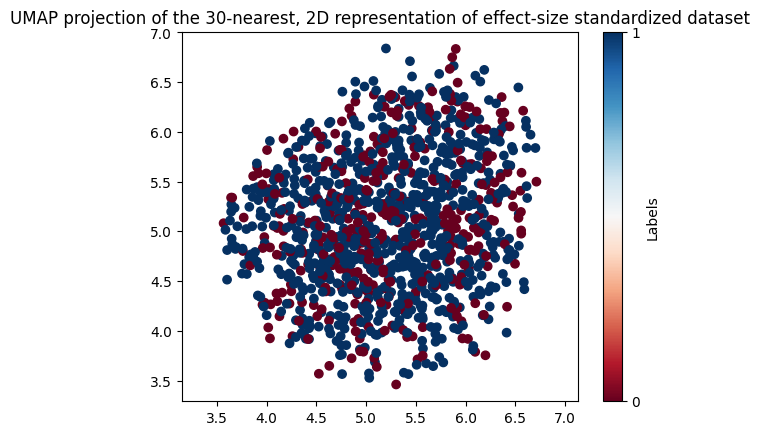

In [176]:
#plt.scatter(embedding[:, 0], embedding[:, 1], c=df_labeled['ADHD_Outcome'].values, cmap='Spectral', s=5)

plt.scatter(embedding[:, 0], embedding[:, 1], c=df_labeled['ADHD_Outcome'].values, 
            cmap=plt.cm.RdBu,  # Red-Blue diverging colormap
            norm=plt.Normalize(vmin=0, vmax=1))

plt.gca().set_aspect('equal', 'datalim')

plt.colorbar(ticks=[0, 1], label='Labels')

plt.title('UMAP projection of the 30-nearest, 2D representation of effect-size standardized dataset')


In [186]:
embedding[:, 2].astype(float)

array([3.77011514, 3.91180968, 4.49170399, ..., 3.31492996, 3.12008572,
       3.73938966])

In [195]:
import plotly.io as pio
pio.renderers.default = "browser"  # This can help if inline rendering fails

In [196]:
# Basic 3D scatter plot
fig = px.scatter_3d(
    x=embedding[:, 0].astype(float),  # First dimension
    y=embedding[:, 1].astype(float),  # Second dimension
    z=embedding[:, 2].astype(float),  # Third dimension
    color=df_labeled['ADHD_Outcome'].values.astype(int),       # Color by labels
    color_continuous_scale='RdBu',  # Red-Blue color scale for binary
    title='3D Scatter Plot of Effect Size Embedding'
)
fig.update_layout(
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    ),
    width=800,
    height=800
)

fig.show()

# df = pd.DataFrame({
#     'x': embedding[:, 0],
#     'y': embedding[:, 1],
#     'z': embedding[:, 2],
#     'label': df_labeled['ADHD_Outcome'].values.astype(int)
# })

# fig = px.scatter_3d(
#     df, 
#     x='x', 
#     y='y', 
#     z='z', 
#     color='label'
# )

# fig.show()

In [191]:
df

,x,y,z,label
0,5.949367,4.702104,3.770115,1
1,5.143324,4.410776,3.911810,1
2,5.256257,5.107381,4.491704,1
3,4.355971,4.911138,3.584879,1
4,4.934638,5.574514,3.887851,1
...,...,...,...,...
1208,3.654019,5.338695,3.524550,0
1209,4.294410,4.106596,3.264756,1
1210,4.416101,3.917753,3.314930,0
1211,3.936980,4.341074,3.120086,1


In [91]:
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# X = np.array([get_upper_triangle_features(conn) for conn in connectomes])
    
# # StandardScaler to handle small numeric values
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)




In [95]:
# # Elbow method to determine optimal number of clusters
# inertias = []
# max_clusters = 50
# for k in range(1, max_clusters + 1):
#     kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)#, n_init=10)
#     kmeans.fit(X_scaled)
#     inertias.append(kmeans.inertia_)

# # Plot elbow curve
# plt.figure(figsize=(8, 8))
# plt.plot(range(1, max_clusters + 1), inertias, marker='o')
# plt.title('Elbow plot')
# plt.xlabel('# Clusters')
# plt.ylabel('Inertia')
# plt.show()

In [96]:
# # Choose optimal number of clusters based on the elbow plot
# optimal_k = 3  # This is a placeholder - you'll determine from the plot
# kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
# cluster_labels = kmeans.fit_predict(X_scaled)

# # Visualize cluster distribution
# plt.figure(figsize=(10, 6))
# for i in range(optimal_k):
#     cluster_count = np.sum(cluster_labels == i)
#     plt.bar(i, cluster_count)
# plt.title('Cluster Distribution')
# plt.xlabel('Cluster')
# plt.ylabel('Number of Subjects')
# plt.show()

# # Optional: Examine how clusters relate to your original labels
# from sklearn.metrics import confusion_matrix
# print("Confusion Matrix (Clusters vs ADHD Labels):")
# print(confusion_matrix(adhd_labels, cluster_labels))